# Testing DrugAgent and DrugEnv APIs

Load data.

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [2]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

In [3]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
pIC50_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [4]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [5]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

Instantiate Environment and Agent.

In [51]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

sequence = [{
    'name': 'design',
    'batch_size': 5,
    'parameters': {'temperature': 0.1, 'size': 8}
}]

for assay in [
    'Noisy Log S', 'Noisy Log P', 'Noisy ABL1 pIC50',
    'make',
    'Log S', 'Log P', 'ABL1 pIC50'
]:
    sequence.append({'name': assay, 'batch_size': 40})

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.0),
    utility_function = utility_agent
)

In [226]:
drug_agent.reset()
observations, _ = drug_env.reset()
action = drug_agent.act(observations)
observations, reward, truncated, terminated, _ = drug_env.step(action)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [186]:
# Helper function
_is_tested = lambda m: all(
    a in m.annotations
    for a in drug_env.assays
    if 'Noisy' not in a
)

In [190]:
filtered_obs = observations.filter(_is_tested)
filtered_obs.set_status('tested')

In [209]:
for molecule in observations.molecules:
    molecule.status = 'tested'

In [212]:
observations.update_annotations()

MoleculeCollection with 45 Molecules

In [213]:
observations.annotations.reindex(columns=[*drug_env.assays, 'status'])

,ABL1 pIC50,Log P,Log S,Noisy ABL1 pIC50,Noisy Log P,Noisy Log S,status
0,NaN,NaN,NaN,NaN,NaN,NaN,tested
1,NaN,NaN,NaN,NaN,NaN,NaN,tested
2,NaN,NaN,NaN,NaN,NaN,NaN,tested
3,NaN,NaN,NaN,NaN,NaN,NaN,tested
4,NaN,NaN,NaN,NaN,NaN,NaN,tested
5,6.884085,1.78330,-1.457339,7.281722,1.856612,-2.299445,tested
6,6.375264,0.38150,-1.603225,5.082166,1.801157,-0.877144,tested
7,5.960647,0.33822,-1.622002,6.768045,1.004893,-1.938807,tested
8,6.437180,1.52440,-0.896519,7.138862,3.278154,-1.690262,tested
9,6.936503,2.05080,-1.906214,8.124875,1.542633,-2.172068,tested


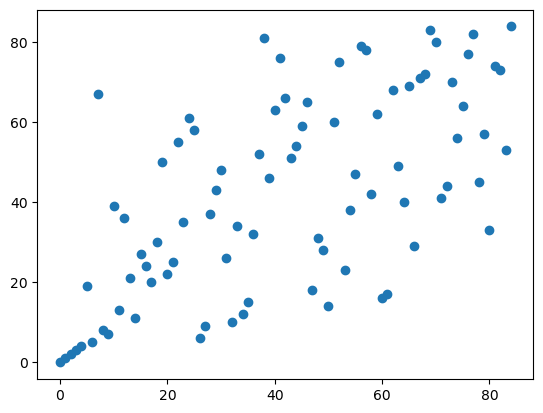

In [139]:
import matplotlib.pyplot as plt
plt.scatter(ranks_actual, ranks_pred)

In [91]:
drug_agent.utility_function(observations, method='average')

[-7.223826424604199,
 -2.5816770815182393,
 -2.7049789366306167,
 -9.874964305216837,
 -6.722718366693622,
 -3.908639293805049,
 -1.8031595038725112,
 -2.5816770815182393,
 -5.964240070416147,
 -6.993121797075177,
 -2.6720218587159166,
 -8.283318020870247,
 -2.965726914050635,
 -2.7049789366306167,
 -3.404528281093625,
 -4.444299737553869,
 -4.4708626468315575,
 -5.231779950409327,
 -5.704308670247916,
 -2.512039147263485,
 -2.438827306773984,
 -3.7945709477216374,
 -4.581534086678325,
 -7.541451063569736,
 -7.339979489304138,
 -3.7452909693583907,
 -5.848575715073633,
 -3.455498198701882,
 -2.609184431479708,
 -6.722718366693622,
 -2.363170321941604,
 -5.83673373941521,
 -8.0280799445559,
 -7.433549518453021,
 -6.237185059316857,
 -6.538984710643013,
 -8.76901678719251,
 -9.874964305216837,
 -10.275154621891488,
 -9.433734333568239,
 -12.764615353103904,
 -11.15627558249508,
 -11.486261925390503,
 -9.608577004834517,
 -13.94588211433528,
 -5.244730575776979,
 -4.309872742506918,
 -2.6